In [1]:
# Librerías

import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Funciones útiles para análisis de ruido

def calculate2DFT(img):
    #Cálculo de la FFT
    fft_img = np.fft.ifftshift(img)
    fft_img = np.fft.fft2(fft_img)
    fft_img = np.fft.fftshift(fft_img)
    return fft_img

def calculateMagnitudSpectrum(img):
    #FFT
    img_fft = calculate2DFT(img)
    #Magnitud Spectrum
    img_ms = 20*np.log10(np.abs(img_fft))
    return img_ms

def calculate2DInverseFT(img_fft):
    # Cálculo de la IFFT
    ift = np.fft.ifftshift(img_fft)
    ift = np.fft.ifft2(ift)
    ift = np.fft.fftshift(ift)
    ift = ift.real
    return ift

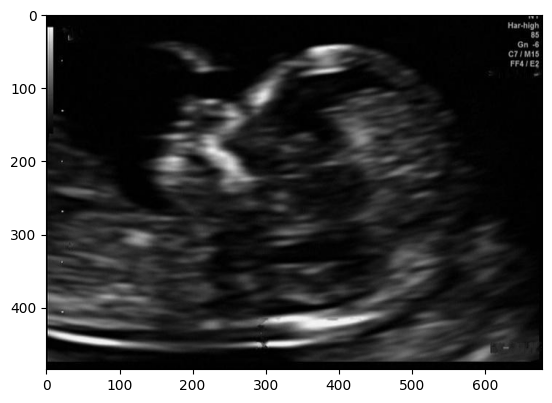

In [48]:
path = "dataset/Set1-Training&Validation Sets CNN/Standard/48.png"
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

plt.imshow(img,cmap='gray')
plt.show()

5.92596933585829 139.9506222108698 60.017721727755934 11.341158048934139


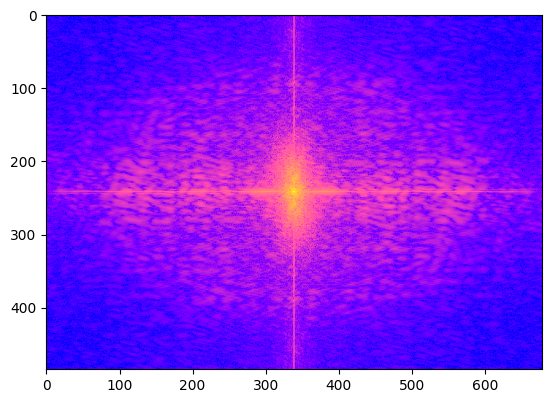

In [50]:
img_ms = calculateMagnitudSpectrum(img)

print(np.min(img_ms),np.max(img_ms),np.mean(img_ms), np.std(img_ms))

plt.imshow(img_ms,cmap='gnuplot2')
plt.show()

In [3]:
def cr8MaskForNoise(img,thresh_list=None):
    img_ms = calculateMagnitudSpectrum(img)
    
    if thresh_list == None:
        thresh_min = np.min(img_ms)
        thresh_max = np.max(img_ms)
    else:
        thresh_min = thresh_list[0]
        thresh_max = thresh_list[1]
    
    mask = img_ms
    mask[mask<thresh_min] = 1.0
    mask[mask>thresh_max] = 1.0
    mask[mask != 1.0] = 0.0
    
    return mask

def cr8MaskForSignal(img,thresh_list=None):
    img_ms = calculateMagnitudSpectrum(img)
    
    if thresh_list == None:
        thresh_min = np.min(img_ms)
        thresh_max = np.max(img_ms)
    else:
        thresh_min = thresh_list[0]
        thresh_max = thresh_list[1]
    
    mask = img_ms
    mask[mask<thresh_min] = 0.0
    mask[mask>thresh_max] = 0.0
    mask[mask != 0.0] = 1.0
    
    return mask

In [4]:
def denoisingFFT(img,ths_list,mode='1'):
    
    if mode == '0':
    
        mask = cr8MaskForNoise(img,ths_list)
    
        img_fft = calculate2DFT(img)
        
        noise = calculate2DInverseFT(img_fft*mask)
        
        dummy0 = img - noise

        dummy1 = dummy0

        dummy1[dummy1 < 0] = 0

        dummy2 = np.uint8(dummy1)
        
        return dummy2
    
    elif mode == '1':
        mask = cr8MaskForSignal(img,ths_list)
        
        img_fft = calculate2DFT(img)
        
        signal = calculate2DInverseFT(img_fft*mask)
        
        signal[signal < 0] = 0
        
        signal = np.uint8(signal)
        
        return signal


In [5]:
def lukinoising(img,alpha=0.5,beta=0.5):
    
    equ = cv2.equalizeHist(img)

    img_ms = calculateMagnitudSpectrum(equ)

    umbral_inferior = np.uint16(np.mean(img_ms)+alpha*np.std(img_ms))
    umbral_superior = np.uint16(np.max(img_ms)-beta*np.std(img_ms))

    new_img = denoisingFFT(equ,[umbral_inferior,umbral_superior],mode='1')

    return new_img

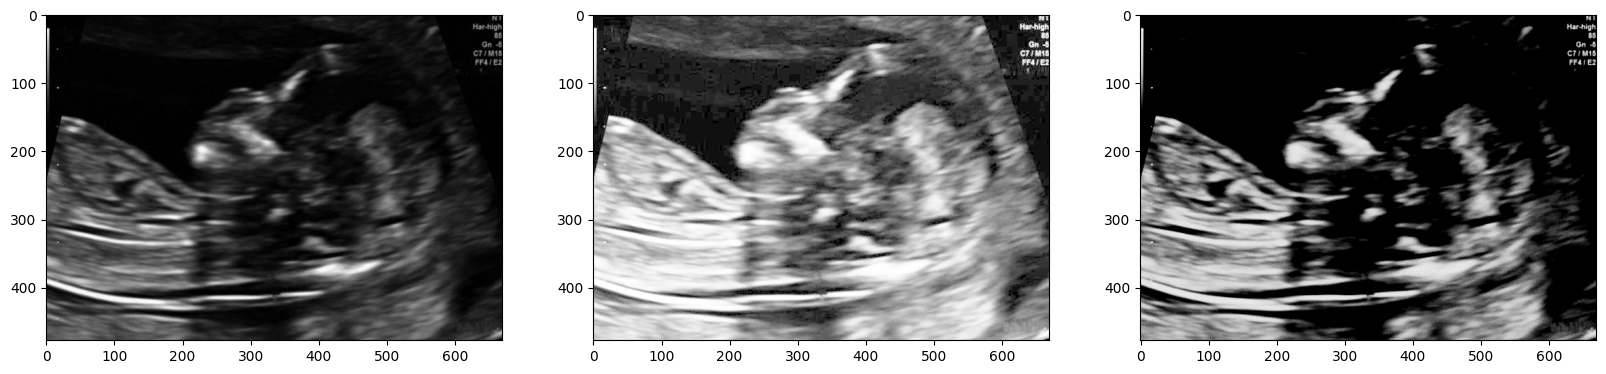

In [9]:
path = "dataset/Set1-Training&Validation Sets CNN/Standard/13.png"
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)

equ = cv2.equalizeHist(img)

img_ms = calculateMagnitudSpectrum(equ)

umbral_inferior = np.uint16(np.mean(img_ms)+0.5*np.std(img_ms))
umbral_superior = np.uint16(np.max(img_ms)-0.5*np.std(img_ms))

new_img = denoisingFFT(equ,[umbral_inferior,umbral_superior],mode='1')

fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(1,3,1)
ax.imshow(img,cmap='gray')

ax = fig.add_subplot(1,3,2)
ax.imshow(equ,cmap='gray')

ax = fig.add_subplot(1,3,3)
ax.imshow(new_img,cmap='gray')


plt.show()

C:\Users\Lucas\AppData\Local\Temp\ipykernel_9812\1343241699.py:23: RuntimeWarning: overflow encountered in scalar subtract
  mask = cr8MaskForNoise(img,[umbral_inferior-100,umbral_superior])


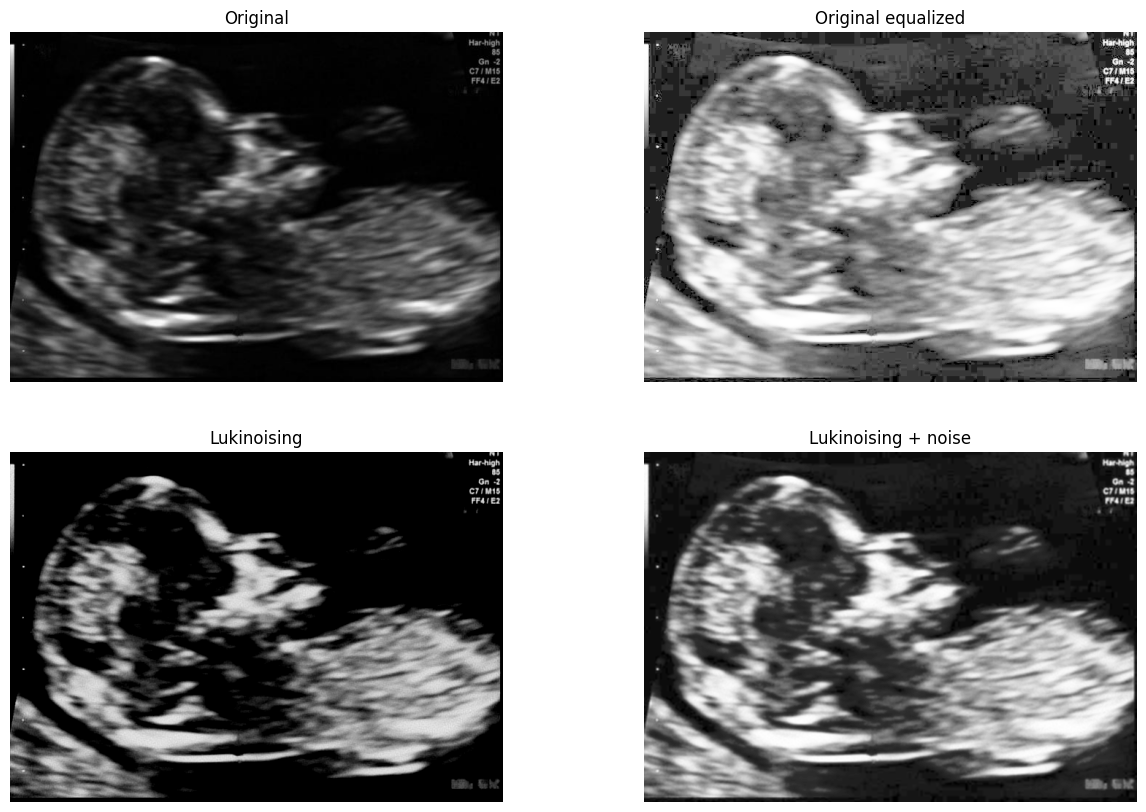

In [65]:
path = "dataset/Set2-Training&Validation Sets ANN Scoring system/Standard/815.png"
img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
equ = cv2.equalizeHist(img)
new_img = lukinoising(img,alpha=0.5,beta=0.5)


blur_img = cv2.blur(new_img,(7,7))
img_diff = cv2.absdiff(new_img,np.uint8(0.15*blur_img))

img_diff2 = cv2.absdiff(img_diff,np.uint8(0.15*cv2.blur(img_diff,(5,5))))
img_equ = cv2.equalizeHist(img_diff2)

img_diff3 = cv2.absdiff(img_equ,np.uint8(0.15*cv2.blur(img_equ,(3,3))))
img_equ2 = cv2.equalizeHist(img_diff3)




img_ms = calculateMagnitudSpectrum(equ)
umbral_inferior = np.uint16(np.mean(img_ms)+0.5*np.std(img_ms))
umbral_superior = np.uint16(np.max(img_ms)-0.5*np.std(img_ms))

mask = cr8MaskForNoise(img,[umbral_inferior-100,umbral_superior])   
img_fft = calculate2DFT(equ)
noise = calculate2DInverseFT(img_fft*mask)


fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(2,2,1)
ax.imshow(img,cmap='gray')
ax.set_title('Original')
ax.set_axis_off()

ax = fig.add_subplot(2,2,2)
ax.imshow(equ,cmap='gray')
ax.set_title('Original equalized')
ax.set_axis_off()

ax = fig.add_subplot(2,2,3)
ax.imshow(new_img,cmap='gray')
ax.set_title('Lukinoising')
ax.set_axis_off()

ax = fig.add_subplot(2,2,4)
#ax.imshow(img_equ2+0.5*noise,cmap='gray')
ax.imshow(cv2.blur(np.uint8(120*(img_equ2/255))+0.3*noise,(3,3)),cmap='gray')
ax.set_title('Lukinoising + noise')
ax.set_axis_off()

plt.show()


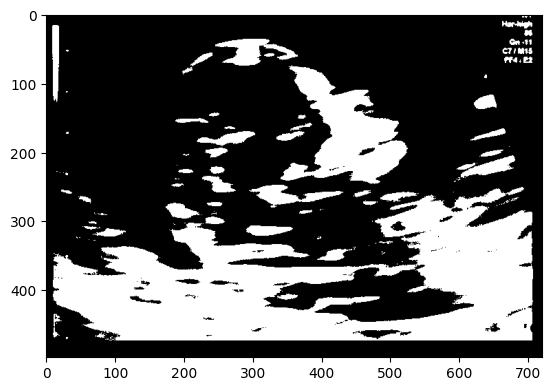

In [26]:
ret, thresh1 = cv2.threshold(new_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  

plt.imshow(thresh1,cmap='gray')
plt.show()